1. Processes individual raw weather station files (adapted from Vasu's code). 
2. Merges them into a unified dataset. 
3. Runs PCA to retain 95% of explained variance and reports dropped features.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from constants import DROP_COLUMNS, CITY_NAMES, DATE_RANGE, NUMERICAL_COLUMNS, COLUMN_ORDER

# 1. Process raw NOAA files and split per station
def process_data(file_basename):
    df = pd.read_csv(f"data/raw/{file_basename}.csv")
    df = df.drop(columns=DROP_COLUMNS, errors="ignore")
    df["DATE"] = pd.to_datetime(df["DATE"])

    groups = df.groupby("NAME")

    for station_name, station_data in groups:
        city_found = False
        for city in CITY_NAMES:
            if city in station_name:
                station_name = city
                station_data["NAME"] = city
                CITY_NAMES.remove(city)
                city_found = True
                break

        if not city_found:
            print(f"Skipping unknown station: {station_name}")
            continue

        station_data.set_index("DATE", inplace=True)
        station_data = station_data.sort_index().reindex(DATE_RANGE)
        station_data.index.name = "DATE"  # Ensure DATE is saved correctly

        # Restore static columns
        station_data["NAME"] = station_data["NAME"].fillna(station_name)
        station_data["LATITUDE"] = station_data["LATITUDE"].fillna(station_data["LATITUDE"].mode()[0])
        station_data["LONGITUDE"] = station_data["LONGITUDE"].fillna(station_data["LONGITUDE"].mode()[0])
        station_data["ELEVATION"] = station_data["ELEVATION"].fillna(station_data["ELEVATION"].mode()[0])

        for col in NUMERICAL_COLUMNS:
            if col not in station_data.columns:
                station_data[col] = np.nan
            station_data[col] = station_data[col].fillna(station_data[col].mean())

        station_data = station_data[COLUMN_ORDER]

        os.makedirs("data/processed", exist_ok=True)
        station_data.reset_index().to_csv(f"data/processed/{station_name}.csv", index=False)
        print(f"Processed: {station_name}.csv")

# Run all acronym files
files = ["CMCTB", "RGEDM", "SGASS", "FSALH", "MHWTM", "CHIMM", "SBGAE"]
for f in files:
    process_data(f)

Processed: BUFFALO.csv
Processed: CHICAGO.csv
Processed: CLEVELAND.csv
Processed: MILWAUKEE.csv
Processed: TOLEDO.csv
Processed: DETROIT.csv
Processed: ERIE.csv
Processed: ROCHESTER.csv
Processed: GREEN BAY.csv
Processed: MARQUETTE.csv
Processed: APPLETON.csv
Processed: GRAND RAPIDS.csv
Processed: SAULT STE MARIE.csv
Processed: SOUTH BEND.csv
Processed: SYRACUSE.csv
Processed: ALPENA.csv
Processed: FORT WAYNE.csv
Processed: HOUGHTON LAKE.csv
Processed: LANSING.csv
Processed: SAGINAW.csv
Processed: HIBBING.csv
Processed: MONTELLO.csv
Processed: MUSKEGON.csv
Processed: TRAVERSE CITY.csv
Processed: WATERTOWN.csv
Processed: CHEBOYGAN.csv
Processed: HOUGHTON.csv
Processed: IRONWOOD.csv
Processed: MANISTEE.csv
Processed: MARINETTE.csv
Processed: AUBURN.csv
Processed: BAD AXE.csv
Processed: ESCANABA.csv
Processed: GRAND MARAIS.csv
Processed: SUPERIOR.csv


In [2]:
# 2. Merge all processed station files
def merge_processed_data():
    dfs = []
    for f in os.listdir("data/processed"):
        if f.endswith(".csv"):
            try:
                df = pd.read_csv(f"data/processed/{f}")
                if "DATE" not in df.columns:
                    print(f"Skipping {f} — no DATE column.")
                    continue
                df["DATE"] = pd.to_datetime(df["DATE"])
                df["STATION"] = f.replace(".csv", "")
                df.set_index("DATE", inplace=True)
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {f}: {e}")
    if not dfs:
        raise ValueError("No valid processed CSV files found.")
    merged = pd.concat(dfs)
    merged.sort_index(inplace=True)
    return merged

# Merge and store
merged_df = merge_processed_data()
os.makedirs("data", exist_ok=True)

Selected 11 components to retain 95.0% variance


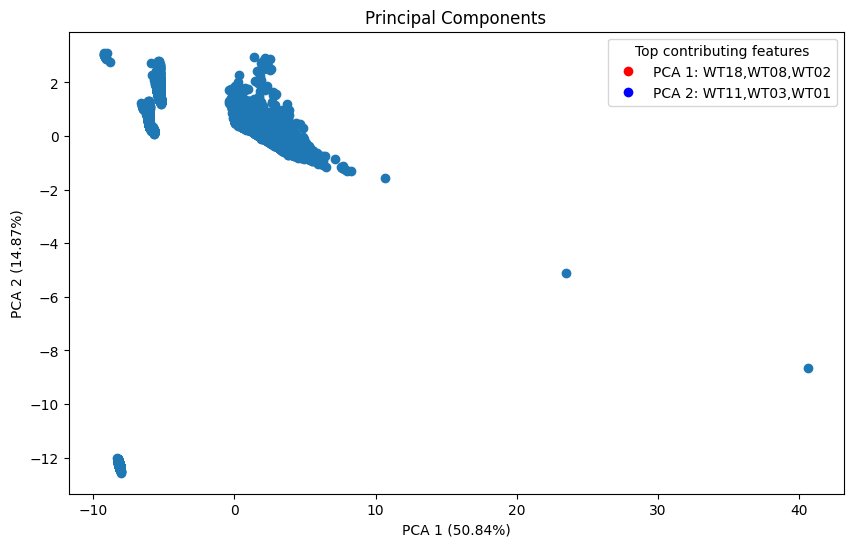

Saved PCA-reduced dataset with original column names to data/merged_pca.csv


In [14]:
# 3. PCA reduction (dynamic threshold)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def run_pca(df, variance_threshold=0.95):
    station_meta = ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION"]
    meta_df = df[station_meta]
    features = df.drop(columns=station_meta, errors="ignore")
    features = features.dropna(axis=1, how="all")
    features = features.fillna(0.0)

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    full_pca = PCA()
    full_pca.fit(X)

    cumulative = full_pca.explained_variance_ratio_.cumsum()
    n_components = np.argmax(cumulative >= variance_threshold) + 1
    print(f"Selected {n_components} components to retain {variance_threshold*100:.1f}% variance")

    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)

    pca_feature_names = features.columns[:n_components]
    pca_df = pd.DataFrame(X_reduced, index=features.index, columns=pca_feature_names)
    final_df = pd.concat([meta_df, pca_df], axis=1)
    fig, ax = plt.subplots(figsize=(10, 6)) 
    ax.scatter(final_df.iloc[:, 5:7].iloc[:, 0], final_df.iloc[:, 5:7].iloc[:, 1])
    ax.set_xlabel(f'PCA 1 ({full_variance[0] * 100:.2f}%)')
    ax.set_ylabel(f'PCA 2 ({full_variance[1] * 100:.2f}%)')
    ax.set_title(f"Principal Components")
    top_features = {}
    for i in range(2):
        feature_idx = np.abs(pca_model.components_[i]).argsort()[-3:]
        top_features[f'PCA {i + 1}'] = ','.join(features.columns[feature_idx])

    colors = ['red', 'blue']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{key}: {value}", markerfacecolor=color, markersize=8)
                       for key, value, color in zip(top_features.keys(), top_features.values(), colors)]
    
    # Create a single legend with the custom legend entries
    ax.legend(handles=legend_elements, title="Top contributing features", loc='upper right')
    plt.show()
    return final_df, n_components, pca, full_pca.explained_variance_ratio_

# Run PCA
final_df, n_components_used, pca_model, full_variance = run_pca(merged_df)
final_df.to_csv("data/merged_pca.csv")
print("Saved PCA-reduced dataset with original column names to data/merged_pca.csv")

In [4]:
# # Load the PCA-transformed dataset and print explained variance by component

# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Load full merged dataset (before PCA)
# merged_df = pd.read_csv("data/merged_full.csv", parse_dates=["DATE"])
# merged_df.set_index("DATE", inplace=True)

# # Extract only numerical features
# station_meta = ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION"]
# features = merged_df.drop(columns=station_meta, errors="ignore")
# features = features.dropna(axis=1, how="all")
# features = features.fillna(0.0)

# # Standardize features
# scaler = StandardScaler()
# X = scaler.fit_transform(features)

# # Fit PCA on all components
# pca = PCA()
# X_pca = pca.fit_transform(X)

# # Store explained variance
# explained_variance = pd.DataFrame({
#     "Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
#     "ExplainedVariance": pca.explained_variance_ratio_,
#     "CumulativeVariance": pca.explained_variance_ratio_.cumsum()
# })

# # Save and print summary
# explained_variance.to_csv("data/pca_variance_full_components.csv", index=False)
# print("Saved explained variance for all PCA components to data/pca_variance_full_components.csv")
# print(explained_variance.head(40))